# Self-Driving Car Engineer Nanodegree

## Vehicle Detection

In this notebook, we will create a pipeline to identify vehicles on a video. To do so, we will need to go over the following steps:
* Extract the features of an image that allow us to classify it as a car (or not a car).
* Train a Classifier that will use the above features to correctly identify images as cars (or not cars).
* Develop a way to canvass the a frame of the video to look for likely vehicles.
* Combine all the above to accurately detect cars in the video.


## Step 1: Extracting features

We begin by implementing the HOG extraction. We will use a few images from our training Data set.

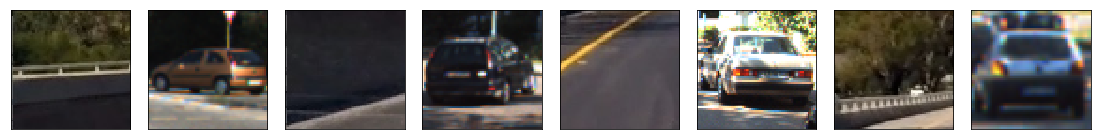

In [1]:
import numpy as np
import cv2
import glob

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import os
%matplotlib inline

# Make a list of calibration images
hog_dir = 'HOGTest'
image_names = [os.path.join(hog_dir, x) for x in os.listdir(hog_dir)]
# Step through the list and search for chessboard corners
images = []
for fname in image_names:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    images.append(img) 

fig = plt.figure(figsize = (15, 15))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.15)
for i in range(len(images)):
    axis = fig.add_subplot(1, len(images), i + 1, xticks=[], yticks=[])
    axis.imshow(images[i])
plt.show()

Above we see eight examples of the images we will use for training. Next, we show how the images look after we apply HOG.

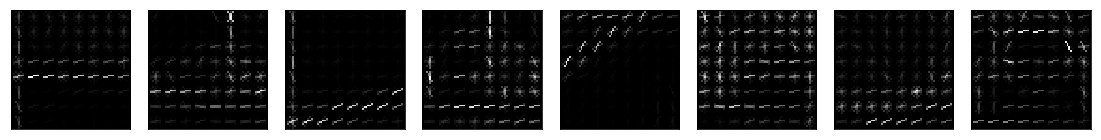

In [2]:
from skimage.feature import hog
pix_per_cell = 8
cell_per_block = 2
orient = 9

fig = plt.figure(figsize = (15, 15))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.15)
for i in range(len(images)):
    img = images[i]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")
    axis = fig.add_subplot(1, len(images), i + 1, xticks=[], yticks=[])
    axis.imshow(hog_image, cmap='gray')

    
plt.show()


Below is our pipeline for the feature extraction. We are using the functions presented in the Udacity classroom.

While researching HOG, we encountered the recommendation to use cv2 instead of scikit and found it to be faster. So we also have the implementation of Open CV Hog below. It is much faster, unfortunately, it always produces a vector, so we can not use it for hog sub-sampling. 


In [3]:

"""
def init_hog(img_shape, orient=9, pix_per_cell=8, cell_per_block=2):
    
    cell_size = (pix_per_cell, pix_per_cell)  # h x w in pixels
    block_size = (cell_per_block, cell_per_block)  # h x w in cells
    nbins = orient  # number of orientation bins

    # winSize is the size of the image cropped to an multiple of the cell size
    hog_params = cv2.HOGDescriptor(_winSize=(img_shape[1] // cell_size[1] * cell_size[1],
                                      img_shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

    return hog_params


def extract_features(imgs, color_space='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # 
    hog_params = None
    features = []
    for fname in imgs:
        
        img = cv2.imread(fname)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
        if hog_params is None:
            hog_params = init_hog(img.shape, orient, pix_per_cell, cell_per_block)

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(hog_params.compute(feature_image[:,:,channel])[:,0])   
            hog_features=np.asarray(hog_features).ravel()
        else:
            hog_features = hog_params.compute(feature_image[:,:,hog_channel])[:,0]
       
        features.append(np.asarray(hog_features))

    return features
"""

# This is the function used in the Udacity classroom

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# This is the function used in the Udacity classroom

def extract_hog_features(imgs, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for fname in imgs:
        # Read in each one by one
        image = cv2.imread(fname)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features



In [4]:
features = extract_hog_features(image_names, color_space='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL')
print(features[0].shape)

(5292,)


/home/strau/anaconda3/envs/carnd/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


## Step 2: Training the classifier

We have the training data provided by Udacity. Part of it is from a time series, which means many of the images are very similar. All of the time series data will be used as part of the training set, with the validation set coming exclusively from KITTI.

In [5]:
import time

cars_KITTI = glob.iglob('Training/vehicles/KITTI/*.png')
cars_GTI = glob.iglob('Training/vehicles/GTI/*.png')
non_cars_KITTI = glob.iglob('Training/non-vehicles/KITTI/*.png')
non_cars_GTI = glob.iglob('Training/non-vehicles/GTI/*.png')

t=time.time()

features_cars_KITTI = extract_hog_features(cars_KITTI, color_space='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL')
features_cars_GTI = extract_hog_features(cars_GTI, color_space='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL')
features_non_cars_KITTI = extract_hog_features(non_cars_KITTI, color_space='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL')
features_non_cars_GTI = extract_hog_features(non_cars_GTI, color_space='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL')

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

print('Number of images of cars (KITTI) ', len(features_cars_KITTI))
print('Number of images of cars (GTI) ', len(features_cars_GTI))
print('Number of images of non cars (KITTI) ', len(features_non_cars_KITTI))
print('Number of images of non cars (GTI) ', len(features_non_cars_GTI))

/home/strau/anaconda3/envs/carnd/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


88.3 Seconds to extract features...
Number of images of cars (KITTI)  5959
Number of images of cars (GTI)  2826
Number of images of non cars (KITTI)  5064
Number of images of non cars (GTI)  3900


In [6]:
# We want to extract the test set exclusively from the KITTI examples, so we take 30 % of them.
# and then we add the 

X_K = np.vstack((features_cars_KITTI, features_non_cars_KITTI)).astype(np.float64)                        
y_K = np.hstack((np.ones(len(features_cars_KITTI)), np.zeros(len(features_non_cars_KITTI))))
X_train, X_test, y_train, y_test = train_test_split(X_K, y_K, test_size=0.3)

X_train = np.vstack((X_train, features_cars_GTI, features_non_cars_GTI)).astype(np.float64)  
y_train = np.hstack((y_train, np.ones(len(features_cars_GTI)), np.zeros(len(features_non_cars_GTI))))

X_train, y_train = shuffle(X_train, y_train)

X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
t=time.time()
X_train = X_scaler.transform(X_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

0.74 Seconds to extract features...


In [7]:
# fit a classifier
svc = LinearSVC()
svc.fit(X_train, y_train)
X_test = X_scaler.transform(X_test)
print('Test Accuracy of Classifier = ', round(svc.score(X_test, y_test), 4))


Test Accuracy of Classifier =  0.9936



## Step 3: Searching for cars

We are now ready to look for cars in an image. To do so, we will consider different regions of the main image and use the classifier to decide whether that region contains a car or not.

The function below takes an image, the search region (defined as the sub rectangle where we expect to find cars) and the parameters for our search, namely, the size of the windows which we will classify, and the overlay we will use in the search.

In [8]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, xstart = 0, xstop= None):
    window_list =[]
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    if xstop == None:
        xstop=img.shape[1]
    img_tosearch = img[ystart:ystop,xstart:xstop,]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
  
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)  

    for xb in range(nxsteps):
        
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell           

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))        
            
            #test_prediction = svc.predict(test_features)
            dec = svc.decision_function(test_features)            
            
            
            if (dec > 0.6):
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                window_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            
                          
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

/home/strau/anaconda3/envs/carnd/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


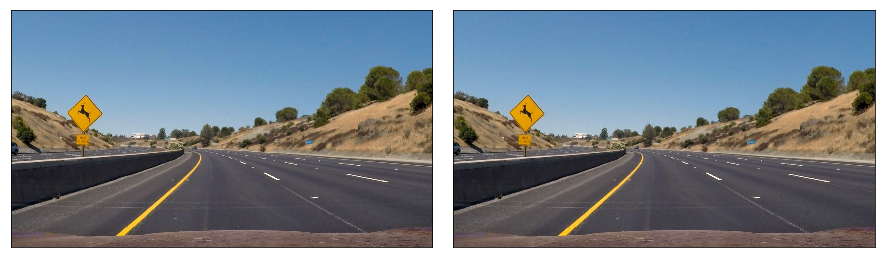

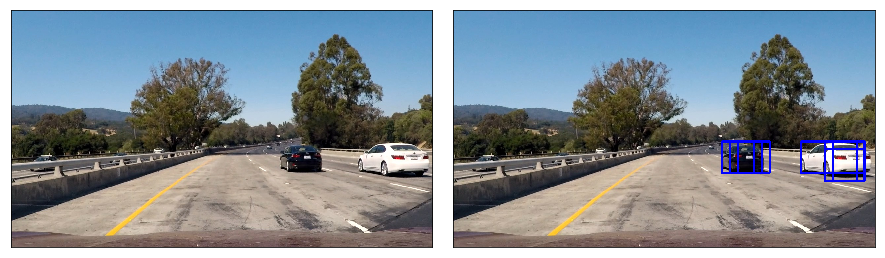

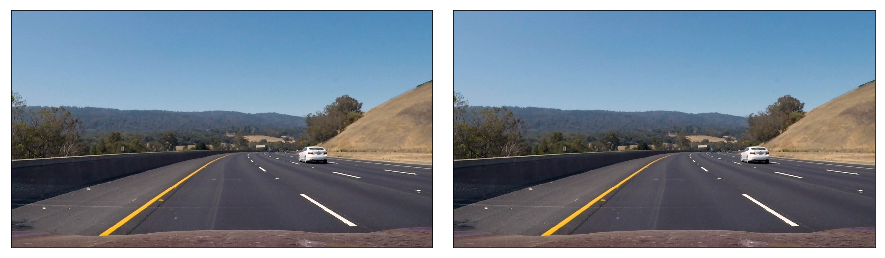

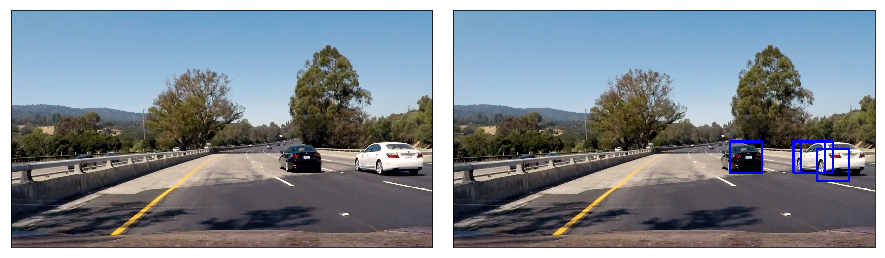

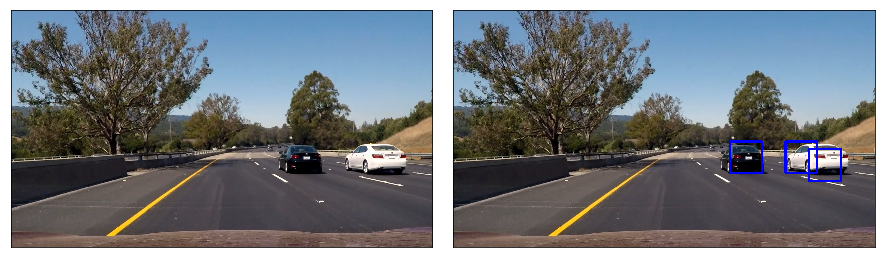

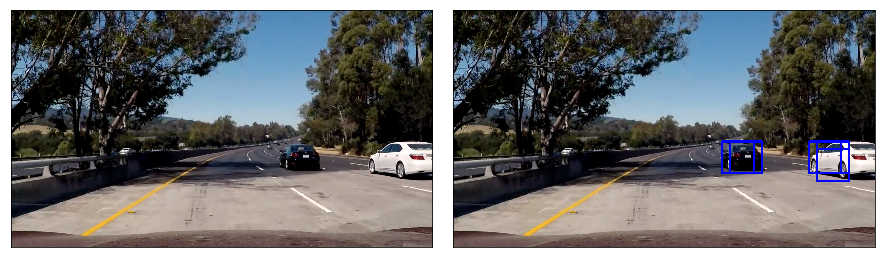

In [9]:
#from source import subsampler as ssp
test_dir = 'test_images'
test_names = [os.path.join(test_dir, x) for x in os.listdir(test_dir)]

ystart = 400
ystop = 656
scale = 1.5

for tnames in test_names:    
    image = cv2.imread(tnames)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    out_img = draw_boxes(image, windows)
    fig = plt.figure(figsize = (12, 6))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    axis.imshow(image)
    axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    axis.imshow(out_img)
    plt.show()

In [10]:
from scipy.ndimage.measurements import label


def add_heat(heatmap, bbox_list, heatlevel=1):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += heatlevel

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 4)
    # Return the image
    return img





So far we have developed a way to identify possible locations of cars in an image using sliding windows, and we have used heat maps as a way of putting together all the resulting information. Below, we implement a class that will allows us to keep the information gathered over the last few frames, allowing us to discard false positives and retain previous detections better, enhancing our classifier performance.

In [11]:
# This class will allow us to incorporate all the functionality we have built
# and process a video.
from collections import deque

class Detector(object):   

    def __init__(self, classifier, scaler, image):      
        
        self.classifier = classifier
        self.scaler = scaler        
        self.image_shape = image.shape
        self.past_windows = deque(maxlen=25)
        self.heatmap = np.zeros((self.image_shape[0], self.image_shape[1])).astype(np.float)

    def process(self, image):
        # This function takes in an image and returns the
        # final version (with identified vehicles)
        
        self.detections(image)
        threshold = min(len(self.past_windows), 12)
        heatmap = self.create_heatmap(threshold)
        labels = label(heatmap)
        final_image = draw_labeled_bboxes(np.copy(image), labels)
            
        return final_image

    def detections(self, image):
        # Find likely vehicles and add windows to past window list
        pix_per_cell = 8
        cell_per_block = 2
        orient = 9        
        
        windows = find_cars(image, 400, 630, 3, self.classifier, self.scaler, orient, pix_per_cell, cell_per_block,0,192)
        windows += find_cars(image, 400, 630, 3, self.classifier, self.scaler, orient, pix_per_cell, cell_per_block, self.image_shape[1]-192, self.image_shape[1])
        windows += find_cars(image, 400, 600, 2.5, self.classifier, self.scaler, orient, pix_per_cell, cell_per_block)
        windows += find_cars(image, 380, 560, 2.0, self.classifier, self.scaler, orient, pix_per_cell, cell_per_block)
        windows += find_cars(image, 380, 520, 1.5, self.classifier, self.scaler, orient, pix_per_cell, cell_per_block)
        windows += find_cars(image, 380, 520, 1.0, self.classifier, self.scaler, orient, pix_per_cell, cell_per_block)
                
        self.past_windows.append(windows)        
        return    

    def create_heatmap(self, threshold):
        # Uses most recent detections to create heatmap
        heatmap = np.zeros((self.image_shape[0], self.image_shape[1])).astype(np.float)
        #j = 0
        for windows in self.past_windows:
            #j += 1
            heatmap = add_heat(heatmap,windows)
        #threshold = (threshold*(1+j)//3)-1
        heatmap = apply_threshold(heatmap,threshold) 
        heatmap = np.clip(heatmap, 0, 255)
        self.heatmap = heatmap
       
        return heatmap

/home/strau/anaconda3/envs/carnd/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


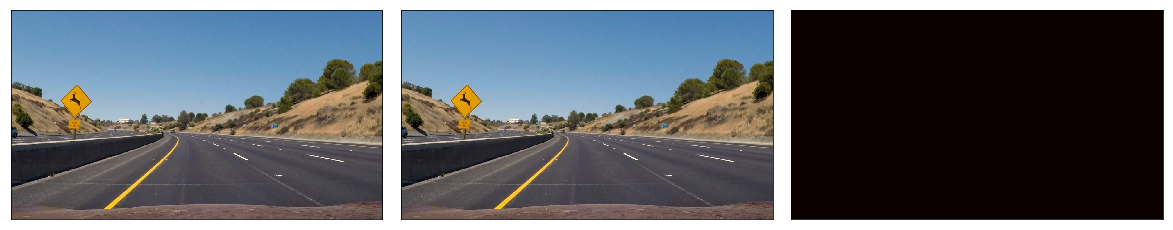

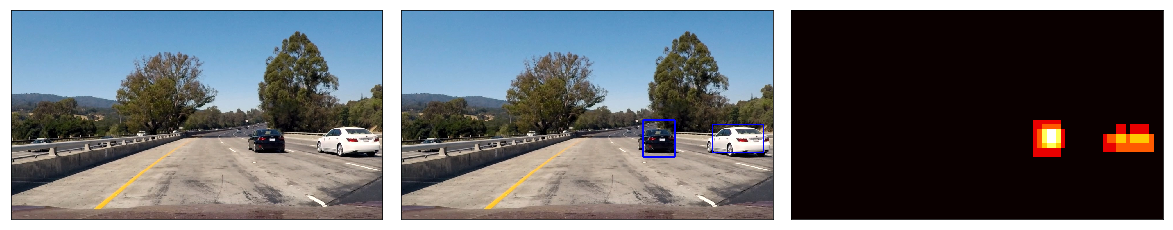

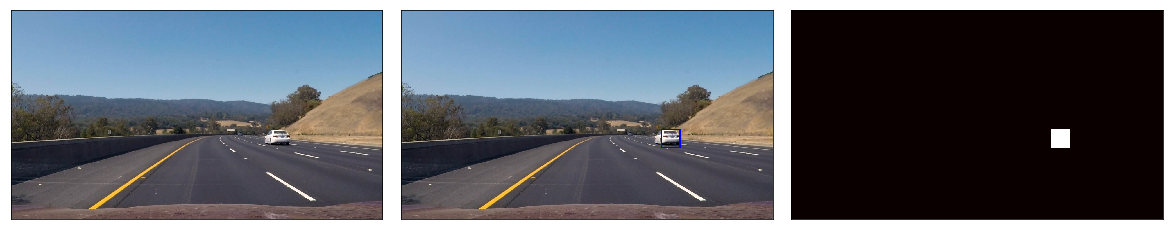

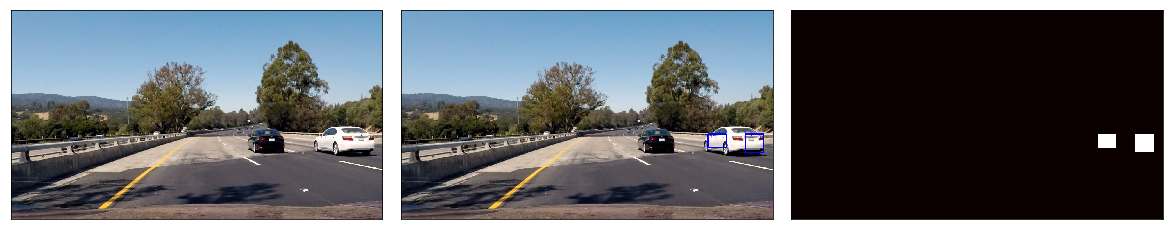

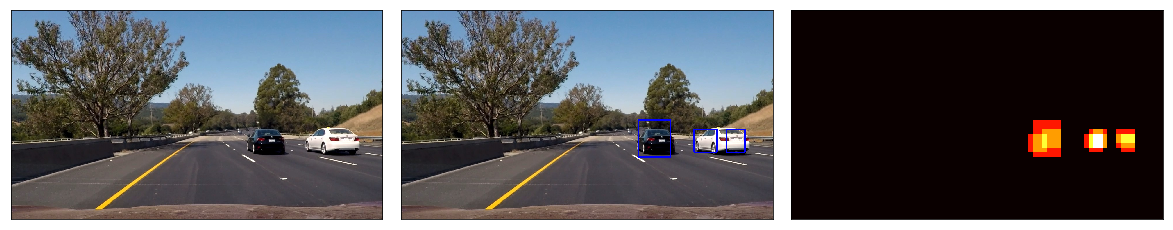

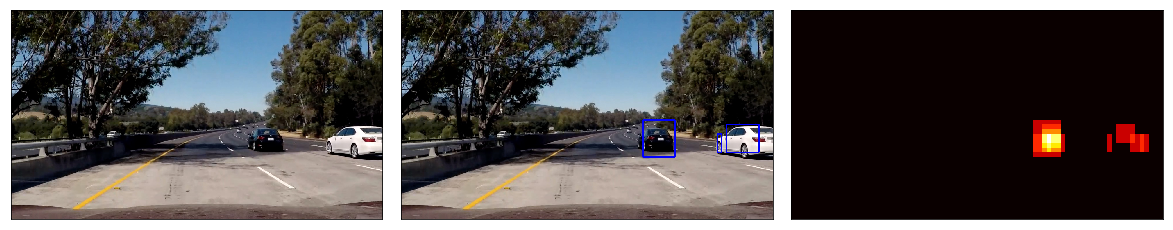

In [12]:

for tnames in test_names:    
    image = cv2.imread(tnames)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    detector = Detector(svc, X_scaler, image)
    found = detector.process(image)
    fig = plt.figure(figsize = (16, 8))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    axis = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
    axis.imshow(image)
    axis = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
    axis.imshow(found)
    axis = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
    axis.imshow(detector.heatmap, cmap='hot')
    plt.show()




## Step 4: test pipeline with the video.

In [13]:
from moviepy.editor import VideoFileClip

video_output_name = 'good.mp4'
#video = VideoFileClip("project_video.mp4").subclip(25,31)
video = VideoFileClip("project_video.mp4")
detector = Detector(svc, X_scaler, video.get_frame(0))
video_output = video.fl_image(detector.process)
%time video_output.write_videofile(video_output_name, audio=False)

[MoviePy] >>>> Building video good.mp4
[MoviePy] Writing video good.mp4


100%|█████████▉| 1260/1261 [2:40:49<00:07,  7.63s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: good.mp4 

CPU times: user 2h 42min 54s, sys: 1min 57s, total: 2h 44min 51s
Wall time: 2h 40min 50s
